In [1]:
import pandas as pd
import joblib
import os

# Carregar o modelo da Premier League novamente (caso ainda não esteja carregado)
modelo_path = os.path.join(os.path.dirname(os.getcwd()), 'models', 'modelo_home_xg.pkl')
modelo_home = joblib.load(modelo_path)


# 1. Carregar os dados do Brasileirão
df_bra = pd.read_csv('../data/brasileirao/brasileirao_scores.csv', encoding='cp1252')
df_bra.columns = ['Wk', 'Day', 'Date', 'Time', 'Home', 'xG_Home', 'Score', 'xG_Away',
                  'Away', 'Attendance', 'Venue', 'Referee', 'Match_Report', 'Notes']

# 2. Padronizar nomes dos times
df_bra['Home'] = df_bra['Home'].str.strip().str.lower()
df_bra['Away'] = df_bra['Away'].str.strip().str.lower()

# 3. Filtrar jogos realizados com placar completo (formato "X–Y")
df_realizados = df_bra[df_bra['Score'].str.contains(r'^\d+–\d+$', na=False)].copy()

# 4. Converter xG para float antes do agrupamento
df_realizados['xG_Home'] = df_realizados['xG_Home'].astype(float)
df_realizados['xG_Away'] = df_realizados['xG_Away'].astype(float)

# 5. Calcular médias de xG por time
home_avg_xG = df_realizados.groupby('Home')['xG_Home'].mean().reset_index()
away_avg_xG = df_realizados.groupby('Away')['xG_Away'].mean().reset_index()
home_avg_xG.columns = ['team', 'avg_home_xG']
away_avg_xG.columns = ['team', 'avg_away_xG']

# 6. Selecionar jogos futuros (sem placar completo)
df_futuros = df_bra[~df_bra['Score'].str.contains(r'^\d+–\d+$', na=False)].copy()

# 7. Merge das médias de xG com os jogos futuros
df_futuros = df_futuros.merge(home_avg_xG, left_on='Home', right_on='team', how='left')
df_futuros = df_futuros.merge(away_avg_xG, left_on='Away', right_on='team', how='left')
df_futuros.drop(columns=['team_x', 'team_y'], inplace=True)

# 7.1 Limpa jogos com dados inválidos (linhas em branco, times faltando, etc.)
df_futuros = df_futuros[df_futuros['Home'].notna() & df_futuros['Away'].notna()]
df_futuros = df_futuros.dropna(subset=['avg_home_xG', 'avg_away_xG'])


# 8. Carregar o modelo salvo da Premier League
modelo_path = os.path.join(os.path.dirname(os.getcwd()), 'models', 'modelo_home_xg.pkl')
modelo_home = joblib.load(modelo_path)

# 9. Fazer predição dos gols do time mandante
X_bra = df_futuros[['avg_home_xG', 'avg_away_xG']]
df_futuros['Predicted_Home_Goals'] = modelo_home.predict(X_bra)

# 10. Visualizar os resultados
df_resultado = df_futuros[['Home', 'Away', 'avg_home_xG', 'avg_away_xG', 'Predicted_Home_Goals']]
print(df_resultado)


                 Home              Away  avg_home_xG  avg_away_xG  \
6       internacional         juventude     1.700000         0.40   
7            mirassol  atlético mineiro     1.750000         1.85   
8               ceará         são paulo     1.700000         0.70   
9        sport recife         fortaleza     0.650000         1.05   
10           flamengo       corinthians     2.500000         0.40   
..                ...               ...          ...          ...   
374  atlético mineiro     vasco da gama     1.300000         0.85   
375          mirassol          flamengo     1.750000         1.50   
376           vitória         são paulo     0.600000         0.70   
377      sport recife            grêmio     0.650000         0.85   
378       corinthians         juventude     1.333333         0.40   

     Predicted_Home_Goals  
6                2.680000  
7                1.640000  
8                2.680000  
9                0.190000  
10               2.175667  
.. 

In [2]:
# Escolha a rodada que você quer prever
rodada = '6'  # ⬅️ Altere esse valor conforme a rodada desejada

df_rodada = df_futuros[df_futuros['Wk'] == rodada].copy()
df_rodada = df_rodada.dropna(subset=['avg_home_xG', 'avg_away_xG'])

X_rodada = df_rodada[['avg_home_xG', 'avg_away_xG']]
df_rodada['Predicted_Home_Goals'] = modelo_home.predict(X_rodada)

df_resultado = df_rodada[['Wk', 'Home', 'Away', 'avg_home_xG', 'avg_away_xG', 'Predicted_Home_Goals']]
print(df_resultado)


   Wk           Home              Away  avg_home_xG  avg_away_xG  \
6   6  internacional         juventude         1.70         0.40   
7   6       mirassol  atlético mineiro         1.75         1.85   
8   6          ceará         são paulo         1.70         0.70   
9   6   sport recife         fortaleza         0.65         1.05   
10  6       flamengo       corinthians         2.50         0.40   
11  6        vitória            grêmio         0.60         0.85   
12  6       cruzeiro     vasco da gama         1.75         0.85   
13  6      palmeiras             bahia         1.35         1.25   
14  6         santos     rb bragantino         1.50         1.05   
15  6  botafogo (rj)        fluminense         1.60         1.05   

    Predicted_Home_Goals  
6               2.680000  
7               1.640000  
8               2.680000  
9               0.190000  
10              2.175667  
11              1.210000  
12              3.520000  
13              1.420000  
14      

C:\Users\Daniel\AppData\Local\Temp\ipykernel_12804\4260123495.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resultado['Match'] = df_resultado['Home'].str.title() + ' x ' + df_resultado['Away'].str.title()


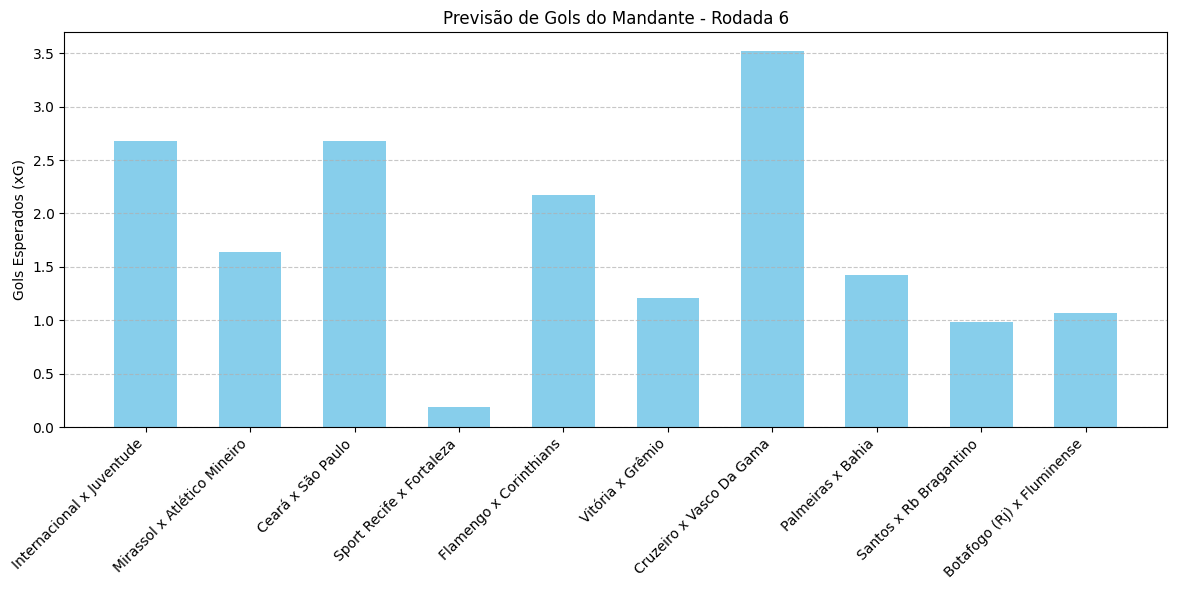

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Cria uma coluna com o confronto em formato "Time A x Time B"
df_resultado['Match'] = df_resultado['Home'].str.title() + ' x ' + df_resultado['Away'].str.title()

# Define posição dos jogos no eixo X
index = np.arange(len(df_resultado))
bar_width = 0.6

# Cria o gráfico de barras
plt.figure(figsize=(12, 6))
plt.bar(index, df_resultado['Predicted_Home_Goals'], bar_width, color='skyblue')

# Configura os rótulos
plt.xticks(index, df_resultado['Match'], rotation=45, ha='right')
plt.ylabel('Gols Esperados (xG)')
plt.title(f'Previsão de Gols do Mandante - Rodada {rodada}')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [4]:
# Prever gols do visitante — usando o modelo do mandante com os nomes esperados
X_visitante = df_rodada[['avg_away_xG', 'avg_home_xG']].copy()
X_visitante.columns = ['avg_home_xG', 'avg_away_xG']  # mesmo nome e ordem do treino

df_rodada['Predicted_Away_Goals'] = modelo_home.predict(X_visitante)


# Somar os gols do mandante e do visitante
df_rodada['Predicted_Total_Goals'] = (
    df_rodada['Predicted_Home_Goals'] + df_rodada['Predicted_Away_Goals']
)


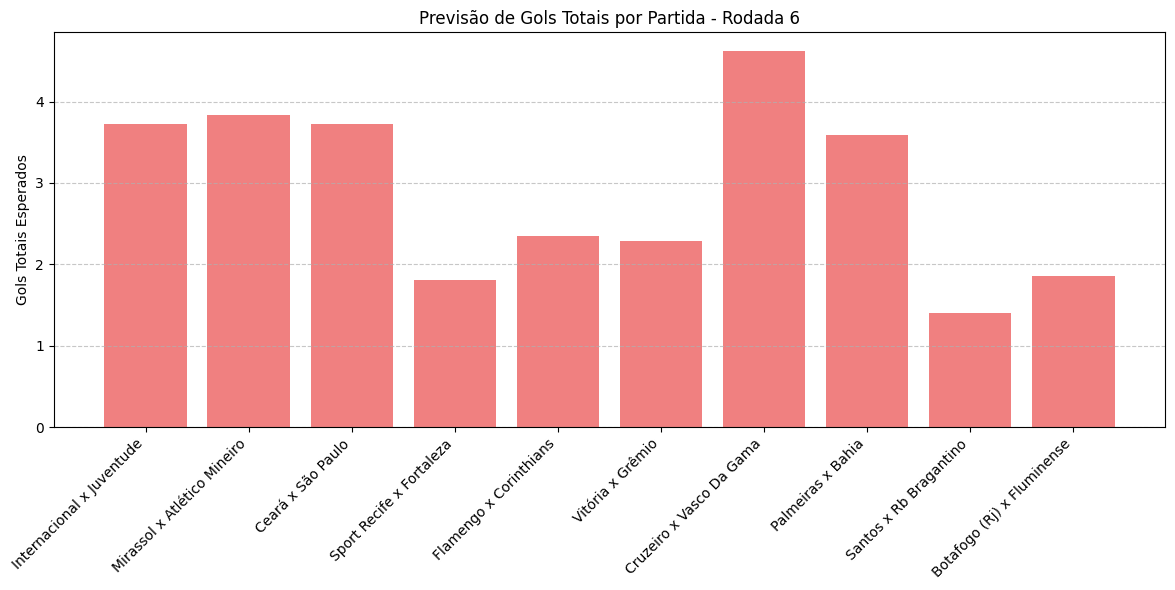

In [5]:
# Atualiza o título dos confrontos se necessário
df_rodada['Match'] = df_rodada['Home'].str.title() + ' x ' + df_rodada['Away'].str.title()

# Gráfico de gols totais
index = np.arange(len(df_rodada))
plt.figure(figsize=(12, 6))
plt.bar(index, df_rodada['Predicted_Total_Goals'], color='lightcoral')

plt.xticks(index, df_rodada['Match'], rotation=45, ha='right')
plt.ylabel('Gols Totais Esperados')
plt.title(f'Previsão de Gols Totais por Partida - Rodada {rodada}')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


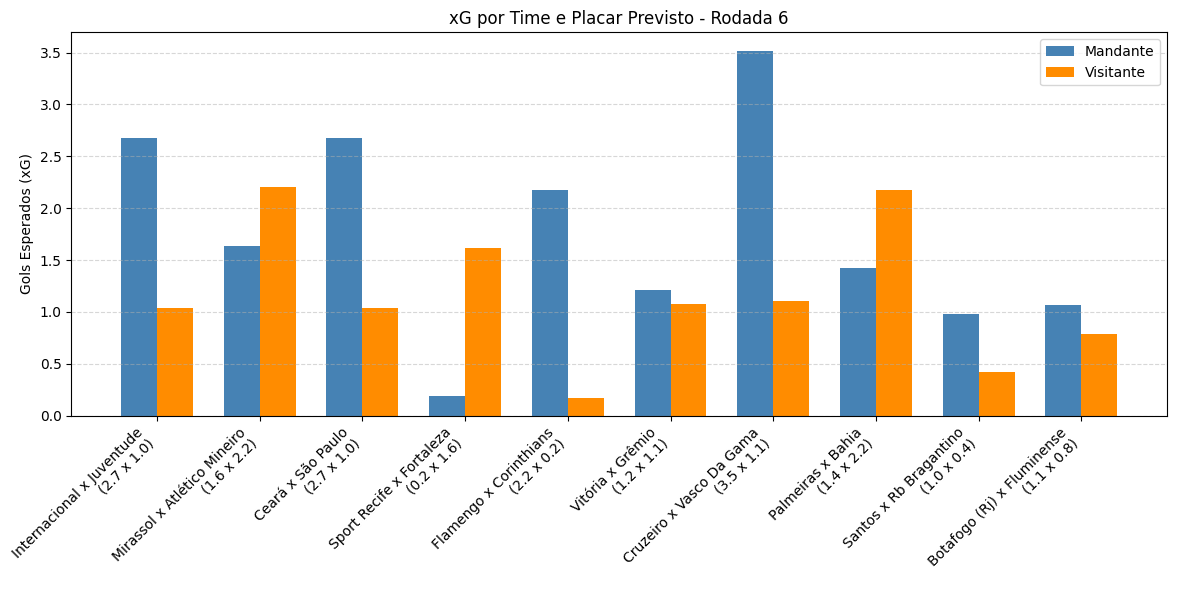

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Criar coluna com placar previsto (arredondado ou uma casa decimal)
df_rodada['Placar_Previsto'] = df_rodada['Predicted_Home_Goals'].round(1).astype(str) + ' x ' + df_rodada['Predicted_Away_Goals'].round(1).astype(str)

# 2. Criar gráfico
plt.figure(figsize=(12, 6))

bar_width = 0.35
index = np.arange(len(df_rodada))

# Barras de xG por time
plt.bar(index, df_rodada['Predicted_Home_Goals'], bar_width, label='Mandante', color='steelblue')
plt.bar(index + bar_width, df_rodada['Predicted_Away_Goals'], bar_width, label='Visitante', color='darkorange')

# Rótulos com placares
match_labels = [
    f"{home.title()} x {away.title()}\n({placar})"
    for home, away, placar in zip(
        df_rodada['Home'],
        df_rodada['Away'],
        df_rodada['Placar_Previsto']
    )
]

plt.xticks(index + bar_width / 2, match_labels, rotation=45, ha='right')
plt.ylabel('Gols Esperados (xG)')
plt.title(f'xG por Time e Placar Previsto - Rodada {rodada}')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
